# CoDaS-HEP Columnar Data Analysis, hands-on project workbook

This is the fourth notebook, the workbook, for the [columnar data analysis](https://indico.cern.ch/event/1287965/timetable/#41-columnar-data-analysis) tutorial, presented at CoDaS-HEP at 13:30pm on July 20, 2023 by Jim Pivarski and Ioana Ifrim.

See the [GitHub repo](https://github.com/ioanaif/columnar-data-analysis-codas-hep-2023) for instructions on how to run it.

<br><br><br><br><br>

## Project: discover the Higgs!

Gather into groups of 2 or 3 to work on the problems posed in the rest of this notebook.

Jim and Ioana will be walking around the room, answering questions and providing hints.

## Data Setup

In [ ]:
import sys
if sys.platform == 'emscripten':
    # Install packages in the browser
    import piplite; await piplite.install(['awkward-cpp', 'awkward>=2.0', 'hist', 'hist[plot]', 'matplotlib', 'mplhep', 'particle', 'scipy', 'vector'])

In [ ]:
import h5py, json, hist, vector
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak

vector.register_awkward()

In [ ]:
rf = h5py.File("data/SMHiggsToZZTo4L-structured.hdf5", "r")
events = ak.from_buffers(
    ak.forms.from_json(rf['awkward'].attrs["form"]),
    json.loads(rf['awkward'].attrs["length"]),
    {k: np.asarray(v) for k, v in rf['awkward'].items()},
)

In [ ]:
#data set up back-up
if sys.platform == 'emscripten':
    from urllib.request import urlopen
    from js import fetch

    URL = "https://cernbox.cern.ch/remote.php/dav/public-files/YaGdBL1FneiX7jQ/worbook-data.json"

    res = await fetch(URL)
    text = await res.text()

    raw_data = ak.from_json(text)
    events = ak.zip({
        "PV": ak.zip({
            "x": raw_data["PV_x"],
            "y": raw_data["PV_y"],
            "z": raw_data["PV_z"],
        }, with_name="Vector3D"),
        "muons": ak.zip({
            "pt": raw_data["Muon_pt"],
            "phi": raw_data["Muon_phi"],
            "eta": raw_data["Muon_eta"],
            "mass": raw_data["Muon_mass"],
            "charge": raw_data["Muon_charge"],
            "pfRelIso03": raw_data["Muon_pfRelIso03_all"],
            "pfRelIso04": raw_data["Muon_pfRelIso04_all"],
        }, with_name="Momentum4D"),
        "electrons": ak.zip({
            "pt": raw_data["Electron_pt"],
            "phi": raw_data["Electron_phi"],
            "eta": raw_data["Electron_eta"],
            "mass": raw_data["Electron_mass"],
            "charge": raw_data["Electron_charge"],
            "pfRelIso03": raw_data["Electron_pfRelIso03_all"],
        }, with_name="Momentum4D"),
        "MET": ak.zip({
            "pt": raw_data["MET_pt"],
            "phi": raw_data["MET_phi"],
        }, with_name="Momentum2D"),
    }, depth_limit=1)

<br><br><br><br><br>

### Higgs mass peak: 4 leptons of the same flavor

Instead of a Z mass peak, formed with 2 muons (or 2 electrons), draw a Higgs mass peak with 4 muons (or 4 electrons).

No need for any cuts, yet. Focus only on the combinatorics.

**Hint:** look at the [ak.combinations](https://awkward-array.readthedocs.io/en/latest/_auto/ak.combinations.html) documentation to find the argument you need to change.

**Hint:** do it in small steps! That's what an interactive environment is for.

In [ ]:
# your work goes here; make new cells if you need to!

Should look like:

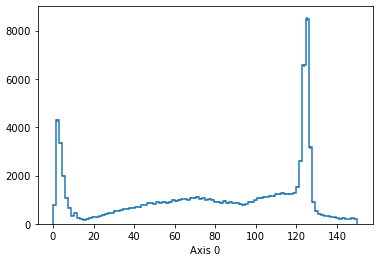

<br><br><br><br><br>

### Charge-based collections

Because of the way that particles are measured and reconstructed, different particle types (electron versus muon) are in different collections, but different charges are not.

But physically, charge is a quantum number just like flavor (particle type), and it can be convenient to put different charges into different collections.

In [ ]:
muons_plus  = events.muons[events.muons.charge > 0]
muons_minus = events.muons[events.muons.charge < 0]
electrons_plus  = events.electrons[events.electrons.charge > 0]
electrons_minus = events.electrons[events.electrons.charge < 0]

<br><br><br><br><br>

Now we can make opposite-sign Z peaks without applying a cut to the combinations.

Also, the [ak.combinations](https://awkward-array.readthedocs.io/en/latest/_auto/ak.combinations.html) problem (picking $n$ items from a single collection) has become an [ak.cartesian](https://awkward-array.readthedocs.io/en/latest/_auto/ak.cartesian.html) problem (finding all pairs of items drawn from different collections).

In [ ]:
mu1, mu2 = ak.unzip(ak.cartesian((muons_plus, muons_minus)))
hist.Hist.new.Regular(100, 0, 150).Double().fill(ak.ravel((mu1 + mu2).mass)).plot();

<br><br>

(This section doesn't have any questions; it's to set things up for the next section.)

<br><br><br><br><br>

### Higgs mass peak: the H → ZZ → 2μ2e final state

Now that you have `muons_plus`, `muons_minus`, `electrons_plus`, and `electrons_minus`, how would you make a Higgs mass peak for decays into 2 muons and 2 electrons?

**Hint:** [ak.cartesian](https://awkward-array.readthedocs.io/en/latest/_auto/ak.cartesian.html) can take more than two input collections.

**Hint:** still no need for cuts, thanks to the input collections already having the charge-cut applied.

In [ ]:
# your work goes here; make new cells if you need to!

Should look like:

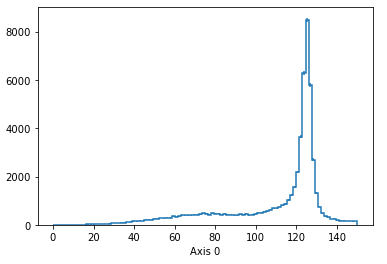

<br><br><br><br><br>

### Select on-shell Z in the 2μ2e final state

In H → ZZ, one of the two Z bosons will usually be close to its "on-shell" mass of 91 GeV.

In [ ]:
import particle
import hepunits

ZMASS = particle.Particle.findall("Z0")[0].mass / hepunits.GeV
ZMASS

With a pair of muons,

In [ ]:
mu1, mu2 = ak.unzip(ak.cartesian((muons_plus, muons_minus)))
e1, e2 = ak.unzip(ak.cartesian((electrons_plus, electrons_minus)))

In [ ]:
hist.Hist.new.Regular(100, 0, 150).Double().fill(ak.ravel((mu1 + mu2).mass)).plot();

We can construct a dimuon mass and compute the absolute distance between that and the on-shell mass of 91 GeV.

In [ ]:
abs((mu1 + mu2).mass - ZMASS)

In [ ]:
ak.ravel(abs((mu1 + mu2).mass - ZMASS))

When this is close enough—let's say 20 GeV—we can call a given dimuon pair to be "on shell."

In [ ]:
onshell_mumu = abs((mu1 + mu2).mass - ZMASS) < 20

The effect of this is a sharp cut-off in the Z mass distribution.

In [ ]:
hist.Hist.new.Regular(100, 0, 150).Double().fill(ak.ravel((mu1 + mu2)[onshell_mumu].mass)).plot();

In this section, make another 2μ2e mass peak in which _either_ the 2μ is on-shell _or_ the 2e is on-shell.

(That's an "inclusive or": having both be close to 91 GeV is allowed.)

**Hint:** You'll have to compute the Z mass constraint from muons and electrons in a 4-way Cartesian product, not just the 2 muons as in my example above.

**Hint:** To make logical combinations of cuts, use `|` for "or" and `&` for "and". Also, put parentheses around any comparisons: e.g. `is_good & ((1 < x) | (x < 2))`.

Should look like:

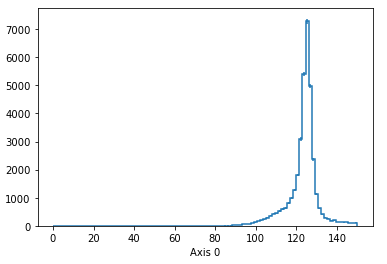

<br><br><br><br><br>

## Select on-shell Z in the 4μ final state

Addressing Z boson properties in the 2μ2e case is easier than in the 4μ or 4e cases because with each (μ⁺, μ⁻, e⁺, e⁻) quad-tuple, there is only one way to identify each of the two Z bosons: Zᵤᵤ → μ⁺μ⁻ and Zₑₑ → e⁺e⁻.

In a same-flavor final state, you have quad-tuples like (μ⁺₁, μ⁻₁, μ⁺₂, μ⁻₂).

The possible decays are

   * Z₁₁ → μ⁺₁, μ⁻₁ and Z₂₂ → μ⁺₂, μ⁻₂
   * Z₁₂ → μ⁺₁, μ⁻₂ and Z₂₁ → μ⁺₂, μ⁻₁

and within each of the two possibilities, only one of the Z bosons will be on-shell. (The Higgs doesn't have enough mass for both to be on-shell.)

To apply Z cuts in this case, we need to apply a combinatoric primitive to the result of a combinatoric primitive: nested combinatorics.

First, from the `muons_plus` collection, we draw two distinct muons and call them `muplus1` and `muplus2`.

Then, from the `muons_minus` collection, we draw two distinct muons and call them `muminus1` and `muminus2`.

In [ ]:
muplus1, muplus2 = ak.unzip(ak.combinations(muons_plus, 2))
muminus1, muminus2 = ak.unzip(ak.combinations(muons_minus, 2))

Next, we need to find pairwise Cartesian products of each opposite-charge combination:

   * pairs of `muplus1 ⊗ muminus1`, which can be labeled "11"
   * pairs of `muplus1 ⊗ muminus2`, which can be labeled "12"
   * pairs of `muplus2 ⊗ muminus1`, which can be labeled "21"
   * pairs of `muplus2 ⊗ muminus2`, which can be labeled "22"

Note that every real combination will either be a "11" and "22" or it will be a "12" and "21".

In [ ]:
muplus11, muminus11 = ak.unzip(ak.cartesian((muplus1, muminus1)))
muplus12, muminus12 = ak.unzip(ak.cartesian((muplus1, muminus2)))
muplus21, muminus21 = ak.unzip(ak.cartesian((muplus2, muminus1)))
muplus22, muminus22 = ak.unzip(ak.cartesian((muplus2, muminus2)))

By construction each of these four collections has the same number of items in each event.

In [ ]:
ak.num(muplus11), ak.num(muplus12), ak.num(muplus21), ak.num(muplus22)

In [ ]:
ak.all((ak.num(muplus11) == ak.num(muplus12)) & (ak.num(muplus21) == ak.num(muplus22)) & (ak.num(muplus11) == ak.num(muplus22)))

We can look at the four possible Z bosons individually.

First the "11" and "22":

In [ ]:
hist.Hist.new.Regular(100, 0, 150).Double().fill(ak.ravel((muplus11 + muminus11).mass)).plot();

In [ ]:
hist.Hist.new.Regular(100, 0, 150).Double().fill(ak.ravel((muplus22 + muminus22).mass)).plot();

Now the "12" and "21":

In [ ]:
hist.Hist.new.Regular(100, 0, 150).Double().fill(ak.ravel((muplus12 + muminus12).mass)).plot();

In [ ]:
hist.Hist.new.Regular(100, 0, 150).Double().fill(ak.ravel((muplus21 + muminus21).mass)).plot();

They all have large backgrounds because they're often not the right combination.

Now we'll make distances as we did in the previous section.

In [ ]:
dist11 = abs((muplus11 + muminus11).mass - ZMASS)
dist12 = abs((muplus12 + muminus12).mass - ZMASS)
dist21 = abs((muplus21 + muminus21).mass - ZMASS)
dist22 = abs((muplus22 + muminus22).mass - ZMASS)

Because we have so many possibilities, let's define cuts like `onshell_11` to mean "11 is the closest to being on-shell."

That doesn't mean it's within 20 GeV of 91 GeV; it just means that it's closer than the others.

(The organization of the cuts is as follows: for each "11", "12", "21", "22", the relevant `dist` is to the left of `<` in all comparisons, and the three other `dist` values it's being compared to are every other "11", "12", "21", "22" combination.)

In [ ]:
onshell_11 = (dist11 < dist12) & (dist11 < dist21) & (dist11 < dist22)
onshell_12 = (dist12 < dist11) & (dist12 < dist21) & (dist12 < dist22)
onshell_21 = (dist21 < dist11) & (dist21 < dist12) & (dist21 < dist22)
onshell_22 = (dist22 < dist11) & (dist22 < dist12) & (dist22 < dist21)

Now let's look at a Z → 2μ mass plot of "11" in which "11" is the closest to being on-shell.

Naturally, there's a more pronounced peak.

In [ ]:
h = hist.Hist.new.Regular(100, 0, 150).Double()

h.fill(ak.ravel((muplus11 + muminus11)[onshell_11].mass))

h.plot();

Now let's look at H → ZZ → 4μ for

   * "11" and "22" if "11" is on-shell or "22" is on-shell
   * "12" and "21" if "12" is on-shell or "21" is on-shell

In [ ]:
h = hist.Hist.new.Regular(100, 0, 150).Double()

h.fill(ak.ravel((muplus11 + muminus11 + muplus22 + muminus22)[onshell_11 | onshell_22].mass))
h.fill(ak.ravel((muplus12 + muminus21 + muplus12 + muminus21)[onshell_12 | onshell_21].mass))

h.plot();

To go further and require "11" to be within 20 GeV of 91 GeV when it's already the closest to it would be a cut like the following:

In [ ]:
onshell_11 & (dist11 < 20)

Now re-make the above plot, but require whichever muon pair is closest to being on-shell to be within 20 GeV of it.

In [ ]:
# your work goes here; make new cells if you need to!

Should look like:

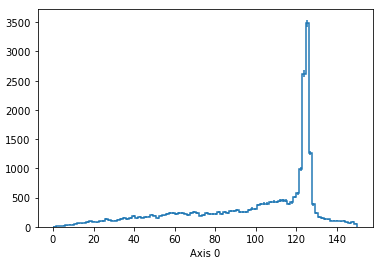

(And compare that to the 4 muon mass without any Z mass constraints!)

<br><br><br><br><br>

### Commentary

Dealing with combinatorics is complex, but by reducing the single μ collection into a μ⁺ collection and a μ⁻ collection, it becomes easier (and more memory efficient) to consider all combinations without having to apply charge constraints after the fact.

Objects like `muplus11`, representing the μ⁺ in all "11" combinations, can be dealt with like scalars, like the single "11" μ⁺ inside a nested loop over combinations in imperative programming. (No array-length changing operations were performed after the two [ak.combinations](https://awkward-array.readthedocs.io/en/latest/_auto/ak.combinations.html), [ak.cartesian](https://awkward-array.readthedocs.io/en/latest/_auto/ak.cartesian.html) steps in the last section.)

But because the `muplus11` object represents the μ⁺ in _all_ "11" combinations, we can plot distributions of what we're computing at every step, rather than just once at the end of a script, which is great for debugging.

That's the value of array-oriented programming—the ability to look at _distributions_ of each step while you develop the script—if you take advantage of that opportunity.

<br><br><br><br><br>

# The end!